<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 1: PyTorch recap / аугментация / OpenCV
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

Семинар состоит из двух частей. В первой мы применим классические методы регуляризации. Во второй сделаем аугментацию данных средствами OpenCV.

Для выполнения работы нужны следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision
* albumentations

Установить их можно командой:
```bash
pip3 install --user opencv-python torch torchvision albumentations
```

In [2]:
!pip3 install opencv-python torchvision albumentations

     |████████████████████████████████| 72 kB 762 kB/s eta 0:00:011
     |████████████████████████████████| 948 kB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 37.6 MB 22.6 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 67.3 MB/s eta 0:00:01    |████▉                           | 4.5 MB 67.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 64.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 72.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 108.3 MB/s eta 0:00:01
     |████████████████████████████████| 162 kB 77.5 MB/s eta 0:00:01


In [3]:
%matplotlib inline
import random

import albumentations
import cv2
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import cvmade
import seminar

print(torch.__version__)

# Параметры тренировки.
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA")


TRAIN = True

TRAIN_KWARGS = {"plot": True,
                "train_plot_kwargs": {"c": "b"},
                "test_scatter_kwargs": {"c": "y", "s": 100, "zorder": 1e10},
                "use_cuda": USE_CUDA}

1.7.0
Use CUDA


# Простая тренировка на CIFAR-10.

## Подготовка данных

Если возникнут трудности при загрузке данных, можно скачать архив по ссылке и самостоятельно распаковать в папку с ноутбуком, так, чтобы рядом с ноутбуком появилась папка cifar-10-batches-py.

Ссылка с данными (если не заработает автоскачивание): https://cloud.mail.ru/public/2ku1/KJPEsJ6xR

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Single image shape (CHW): [3, 32, 32]
Trainset size: 50000
Testset size: 10000
Trainset


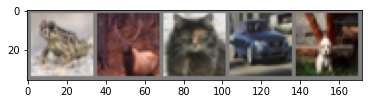


Testset


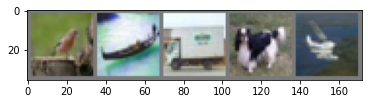

In [4]:
from torchvision.datasets import CIFAR10

DATA_ROOT = "."

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Преобразовать PIL изображения в Torch тензоры.
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
trainset = CIFAR10(DATA_ROOT, train=True, download=True, transform=transform)
testset = CIFAR10(DATA_ROOT, train=False, download=True, transform=transform)
print("Single image shape (CHW):", list(testset[0][0].shape))
print("Trainset size:", len(trainset))
print("Testset size:", len(testset))

print("Trainset")
cvmade.plot.torch.show_images_dataset(trainset)
print("Testset")
cvmade.plot.torch.show_images_dataset(testset)

## Создание модели

Создадим сеть вида VGG (Сокращение от Visual Geometry Group, https://arxiv.org/pdf/1409.1556.pdf ).

Сеть VGG состоит из сверток 3x3, ReLU, max pooling и полносвязных слоев. Оригинальная сеть VGG применялась к изображениям 224x224, мы же применяем к изображениям 32x32. В статье описаны варианты сети VGG с количеством слоев от 11 до 19. Для задачи CIFAR10 достаточно меньшего числа слоев. Итоговая сложность модели позволит нам учить сеть на CPU.

Заметьте, что после pooling слоя площадь изображения уменьшается в 4 раза, а число каналов увеличивается в два раза, т.е. размер тензора уменьшается в два раза. Баланс между размером изображения и числом каналов позволяет сохранить достаточное количество информации при продвижении по сети.

<img src="resources/vgg1.jpg" align="left" hspace="20" width="50%" height="50%"/> 
<img src="resources/vgg2.jpg" align="left" hspace="20" width="50%" height="50%"/>
<div style="clear:both;"></div>

Шпаргалка:

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

torch.nn.ReLU(inplace=False)

torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

torch.nn.Linear(in_features, out_features, bias=True)
```

In [13]:
class VGGNetwork(torch.nn.Sequential):        
    def _make_conv3x3(self, in_channels, out_channels):
        # Начало вашего кода.
        
        layer = torch.nn.Conv2d(
            in_channels, 
            out_channels,
            kernel_size=(3, 3), 
            padding=1, 
            dilation=1
        )
        
        # Конец вашего кода.
        return layer
    
    def _make_relu(self):
        # Начало вашего кода.
        
        layer = torch.nn.ReLU()
        
        # Конец вашего кода.
        return layer
    
    def _make_maxpool2x2(self):
        # Начало вашего кода.
        
        layer = torch.nn.MaxPool2d(
            kernel_size=(2, 2), 
            stride=2,
            padding=0,
            dilation=1
        )
        
        # Конец вашего кода.
        return layer
    
    def _make_fully_connected(self, in_features, out_features, last=False):
        # Начало вашего кода.
        
        layer = torch.nn.Linear(in_features, out_features)
        
        # Конец вашего кода.
        return layer
    
    def __init__(self, n_classes=10):
        # Мы используем same padding, чтобы свертки не меняли ширину и высоту тензоров.
        # Ширина и высота меняются только в maxpool (уменьшаются в два раза).
        layers = [
            self._make_conv3x3(in_channels=3, out_channels=32),
            self._make_conv3x3(in_channels=32, out_channels=32),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=32, out_channels=64),
            self._make_conv3x3(in_channels=64, out_channels=64),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=64, out_channels=128),
            self._make_conv3x3(in_channels=128, out_channels=128),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=128, out_channels=256),
            self._make_conv3x3(in_channels=256, out_channels=256),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            torch.nn.modules.Flatten(),  # Преобразовать 4-мерный тензор BHWC в двумерный BD.
            
            self._make_fully_connected(in_features=256 * 2 * 2, out_features=512),
            self._make_fully_connected(in_features=512, out_features=512),
            self._make_fully_connected(in_features=512, out_features=n_classes, last=True)
        ]
        super().__init__(*layers)
        self.initialize_weights()
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)
                
def count_parameters(model):
    total = 0
    for p in model.parameters():
        total += np.prod(list(p.shape))
    return total
                
vgg = VGGNetwork()
print(vgg)
print("Total parameters: {}".format(count_parameters(vgg)))

seminar.check_vgg(VGGNetwork)

VGGNetwork(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_

## Обучение

Воспользуемся оптимизацией с моментом Нестерова. Будем использовать момент, равный 0.9 и начальный шаг обучения 0.01.

Шпаргалка:

```python
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

torch.optim.SGD(params, lr, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```

In [15]:
vgg.parameters

<bound method Module.parameters of VGGNetwork(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=(2, 2), str

In [16]:
def make_loss():
    # Ваш код, который создает loss.
    
    loss = torch.nn.CrossEntropyLoss()
    
    #
    return loss

def make_optimizer(model):
    # Ваш код, который создает оптимизатор.
    
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=0.01, 
        momentum=0.9, 
        dampening=0,
        weight_decay=0,
        nesterov=True
    )
    
    # Конец вашего кода.
    
    return optimizer

seminar.check_loss_fn(make_loss)
seminar.check_optimizer_fn(make_optimizer)

CHECK OK
CHECK OK


Используем экспоненциально затухающий learning rate.

График изменения learning rate:


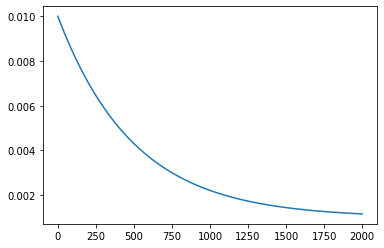

In [17]:
def lr(step):
    return 0.1 + 0.9 * (0.998) ** step

def make_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

xs = np.linspace(0, 2000)
print("График изменения learning rate:")
plt.plot(xs, 0.01 * lr(xs))
plt.show()

<IPython.core.display.Javascript object>


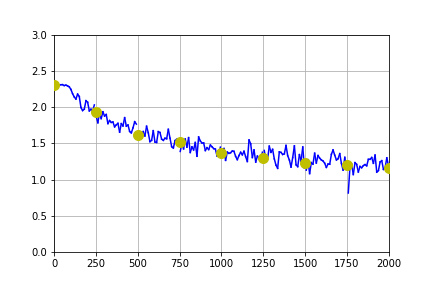

Test loss: 2.3026894828796385
Test accuracy: 0.0972
Step 0
Train loss: 1.9242, learning rate: 0.0065         
Test loss: 1.9277116220474244
Test accuracy: 0.2711
Step 250
Train loss: 1.7222, learning rate: 0.0043         
Test loss: 1.6109265756607056
Test accuracy: 0.39
Step 500
Train loss: 1.5515, learning rate: 0.0030         
Test loss: 1.5126827114105224
Test accuracy: 0.4244
Step 750
Train loss: 1.4878, learning rate: 0.0022         
Test loss: 1.3701461849212646
Test accuracy: 0.4955
Step 1000
Train loss: 1.3074, learning rate: 0.0017         
Test loss: 1.2927395204544068
Test accuracy: 0.5256
Step 1250
Train loss: 1.2711, learning rate: 0.0014         
Test loss: 1.2310677543640136
Test accuracy: 0.5477
Step 1500
Train loss: 1.1774, learning rate: 0.0013         
Test loss: 1.203488531589508
Test accuracy: 0.5545
Step 1750
Train loss: 1.1209, learning rate: 0.0012         
Test loss: 1.1645086882591247
Test accuracy: 0.5757


In [18]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer, trainset, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/01-simple-train.jpg")

# Batchnorm

Batchnorm ( https://arxiv.org/pdf/1502.03167.pdf ) это техника улучшения сходимости сетей с большим количеством слоёв.

Во время тренировки:

<img src="resources/batchnorm.jpg" align="left" width="40%" height="40%"/> 
<div style="clear:both;"></div>

Во время применения статистики по батчу заменяются на более точные статистики по корпусу данных.

Шпаргалка:

```python
torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
```

In [21]:
class VGGNetworkBN(VGGNetwork):
    @staticmethod
    def _make_conv3x3(in_channels, out_channels):
        # Ваш код, который создает слои сети.
        
        conv_layer = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(3, 3),
            padding=1,
            bias=False
        )
        batchnorm_layer = torch.nn.BatchNorm2d(
            out_channels
        ) 
        
        # Конец вашего кода.
        return torch.nn.Sequential(conv_layer, batchnorm_layer)
    
vgg_bn = VGGNetworkBN()
print(vgg_bn)
seminar.check_vgg_bn(VGGNetworkBN)

VGGNetworkBN(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_m

<IPython.core.display.Javascript object>


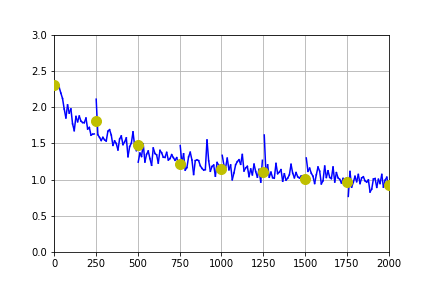

Test loss: 2.3026272483825685
Test accuracy: 0.0986
Step 0
Train loss: 1.8367, learning rate: 0.0065         
Test loss: 1.8024227447509766
Test accuracy: 0.342
Step 250
Train loss: 1.5075, learning rate: 0.0043         
Test loss: 1.473916886138916
Test accuracy: 0.4438
Step 500
Train loss: 1.1894, learning rate: 0.0030         
Test loss: 1.2180057376861573
Test accuracy: 0.5535
Step 750
Train loss: 1.2625, learning rate: 0.0022         
Test loss: 1.1445582117080688
Test accuracy: 0.5788
Step 1000
Train loss: 1.2246, learning rate: 0.0017         
Test loss: 1.1105697970867157
Test accuracy: 0.6027
Step 1250
Train loss: 1.0642, learning rate: 0.0014         
Test loss: 1.0122484269142151
Test accuracy: 0.6388
Step 1500
Train loss: 0.8428, learning rate: 0.0013         
Test loss: 0.9664571215152741
Test accuracy: 0.6515
Step 1750
Train loss: 0.9882, learning rate: 0.0012         
Test loss: 0.9305416170835495
Test accuracy: 0.6653


In [22]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/02-batchnorm.jpg")

# Переобучение

Из соображений производительности, мы используем небольшую сеть. На CIFAR10 она не переобучается. Чтобы воспроизвести ситуацию с переобучением, мы уменьшим количество тренировочных данных.

In [23]:
TRAIN_SUBSET_SIZE = 5000

trainset_small_indices = random.sample(list(range(len(trainset))), TRAIN_SUBSET_SIZE)
trainset_small = torch.utils.data.Subset(trainset, trainset_small_indices)
print("Small trainset size:", len(trainset_small))

Small trainset size: 5000


<IPython.core.display.Javascript object>


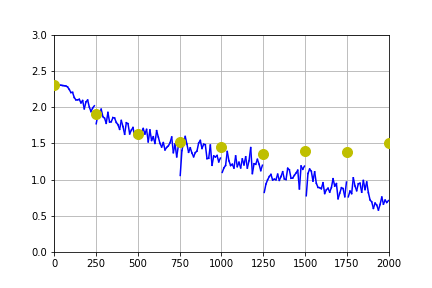

Test loss: 2.302811266708374
Test accuracy: 0.1006
Step 0
Train loss: 1.9238, learning rate: 0.0065         
Test loss: 1.9022270921707154
Test accuracy: 0.2487
Step 250
Train loss: 1.6908, learning rate: 0.0043         
Test loss: 1.6302142200469971
Test accuracy: 0.3771
Step 500
Train loss: 1.5361, learning rate: 0.0030         
Test loss: 1.5130430319786072
Test accuracy: 0.4398
Step 750
Train loss: 1.3650, learning rate: 0.0022         
Test loss: 1.4543493954658508
Test accuracy: 0.4757
Step 1000
Train loss: 1.1513, learning rate: 0.0017         
Test loss: 1.3471850733757018
Test accuracy: 0.5049
Step 1250
Train loss: 1.1665, learning rate: 0.0014         
Test loss: 1.3992646653175353
Test accuracy: 0.5015
Step 1500
Train loss: 0.8526, learning rate: 0.0013         
Test loss: 1.3820654005527497
Test accuracy: 0.538
Step 1750
Train loss: 0.7648, learning rate: 0.0012         
Test loss: 1.508548974609375
Test accuracy: 0.5174


In [24]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/03-overfit.jpg")

## L2 - регуляризация (Тихонова)

К функции потерь добавляется сумма квадратов параметров модели с некотрым весом (weight decay). В итоге модель штрафуется за слишком большие веса модели. Ограничение на диапазон значений параметров приводит к уменьшению переобучения.

<IPython.core.display.Javascript object>


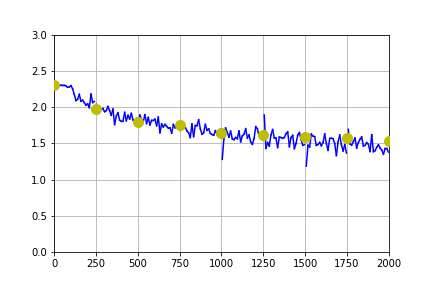

Test loss: 2.3026805961608887
Test accuracy: 0.0962
Step 0
Train loss: 2.0818, learning rate: 0.0065         
Test loss: 1.9767750577926635
Test accuracy: 0.2333
Step 250
Train loss: 1.8185, learning rate: 0.0043         
Test loss: 1.7957569749832154
Test accuracy: 0.3149
Step 500
Train loss: 1.7526, learning rate: 0.0030         
Test loss: 1.7461859024047852
Test accuracy: 0.3411
Step 750
Train loss: 1.6502, learning rate: 0.0022         
Test loss: 1.644512956428528
Test accuracy: 0.3719
Step 1000
Train loss: 1.6216, learning rate: 0.0017         
Test loss: 1.6123183374404908
Test accuracy: 0.3953
Step 1250
Train loss: 1.4560, learning rate: 0.0014         
Test loss: 1.5820279067993164
Test accuracy: 0.3888
Step 1500
Train loss: 1.5518, learning rate: 0.0013         
Test loss: 1.5784972509384154
Test accuracy: 0.4037
Step 1750
Train loss: 1.5174, learning rate: 0.0012         
Test loss: 1.5257106800079345
Test accuracy: 0.4196


In [25]:
WEIGHT_DECAY = 0.01

def make_optimizer_l2_reg(model):
    return torch.optim.SGD(
        model.parameters(),
        lr=0.01, 
        momentum=0.9,
        nesterov=True,
        weight_decay=WEIGHT_DECAY
    )

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer_l2_reg, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/04-l2.jpg")

# Dropout

Свертки содержат мало параметров, они не переобучаются. По-этому, dropout обычно используют в полносвязных слоях.

In [28]:
class VGGNetworkDO(VGGNetwork):
    @staticmethod
    def _make_fully_connected(in_features, out_features, last=False):
        layers = [torch.nn.Linear(in_features, out_features)]
        if not last:
            layers.append(torch.nn.Dropout(p=0.25))
        return torch.nn.Sequential(*layers)
    
vgg_do = VGGNetworkDO()
print(vgg_do)
seminar.check_vgg_do(VGGNetworkDO)

VGGNetworkDO(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, cei

<IPython.core.display.Javascript object>


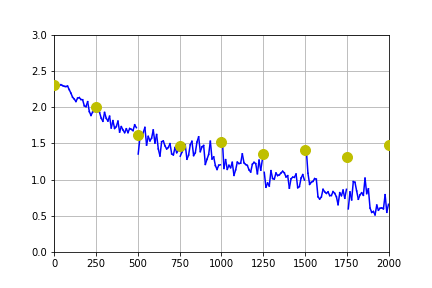

Test loss: 2.30273624458313
Test accuracy: 0.0999
Step 0
Train loss: 1.8990, learning rate: 0.0065         
Test loss: 1.9988098999023438
Test accuracy: 0.2518
Step 250
Train loss: 1.7248, learning rate: 0.0043         
Test loss: 1.6118346126556395
Test accuracy: 0.365
Step 500
Train loss: 1.4441, learning rate: 0.0030         
Test loss: 1.4627024776458741
Test accuracy: 0.4545
Step 750
Train loss: 1.0993, learning rate: 0.0022         
Test loss: 1.5178578350543976
Test accuracy: 0.4529
Step 1000
Train loss: 1.0271, learning rate: 0.0017         
Test loss: 1.353420025253296
Test accuracy: 0.5003
Step 1250
Train loss: 0.9875, learning rate: 0.0014         
Test loss: 1.4090321295261383
Test accuracy: 0.5139
Step 1500
Train loss: 0.9130, learning rate: 0.0013         
Test loss: 1.3141007080078124
Test accuracy: 0.5459
Step 1750
Train loss: 0.5726, learning rate: 0.0012         
Test loss: 1.469409411096573
Test accuracy: 0.5394


In [29]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_do, make_loss, make_optimizer, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/05-dropout.jpg")

## Аугментация

Мы используем следующие аугментации:
1. Rotation / Scale / Offset
2. Random crop
3. Brightness / Contrast
4. Blur

Шпаргалка:
```python
cv2.getRotationMatrix2D(center, angle, scale)  # center: (x, y), angle: градусы, scale: число.

cv2.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])
```

Files already downloaded and verified


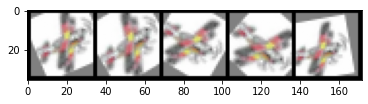

In [32]:
class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_scale=1.1, max_offset=0.1):
        self._min_scale = min_scale
        self._max_scale = max_scale
        self._max_offset = max_offset
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        
        angle = random.random() * 90 - 45
        scale = self._min_scale + random.random() * (self._max_scale - self._min_scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        
        # Ваш код, который преобразует изображение используя угол angle,
        # масштаб scale и смещение (x_offset, y_offset). Фон предлагается закрасить серым цветом.
        
        # Начало вашего кода.
        
        transform = cv2.getRotationMatrix2D((w // 2, h // 2), angle, scale)
        transform[0, 2] += x_offset
        transform[1, 2] += y_offset
        
        new_image = cv2.warpAffine(
            image,
            transform,
            (w, h),
            borderValue=(128,128,128)
        )
        
        # Конец вашего кода.
        
        return Image.fromarray(new_image)  # Numpy -> PIL.

  
%matplotlib inline
seminar.show_augmenter_results(AffineAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-00-affine.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified
Trainset size: 5000


<IPython.core.display.Javascript object>


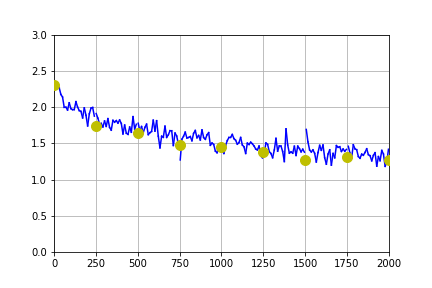

Test loss: 2.302404462814331
Test accuracy: 0.1
Step 0
Train loss: 1.9078, learning rate: 0.0065         
Test loss: 1.7440625921249389
Test accuracy: 0.3552
Step 250
Train loss: 1.5861, learning rate: 0.0043         
Test loss: 1.6352403793334962
Test accuracy: 0.3846
Step 500
Train loss: 1.6240, learning rate: 0.0030         
Test loss: 1.4734857165336608
Test accuracy: 0.4526
Step 750
Train loss: 1.3340, learning rate: 0.0022         
Test loss: 1.452723667907715
Test accuracy: 0.4758
Step 1000
Train loss: 1.4284, learning rate: 0.0017         
Test loss: 1.3854100657463073
Test accuracy: 0.4987
Step 1250
Train loss: 1.4275, learning rate: 0.0014         
Test loss: 1.27509874792099
Test accuracy: 0.5338
Step 1500
Train loss: 1.4580, learning rate: 0.0013         
Test loss: 1.3064524484634399
Test accuracy: 0.5291
Step 1750
Train loss: 1.2900, learning rate: 0.0012         
Test loss: 1.2639123058319093
Test accuracy: 0.5438


In [33]:
augmentation_transform = torchvision.transforms.Compose([
    AffineAugmenter(),
    transform
])
trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True, transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/07-aug-affine.jpg")

Шпаргалка:
```(python)
cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])
```

Files already downloaded and verified


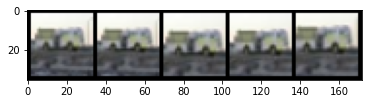

In [40]:
class CropAugmenter(object):
    def __init__(self, min_scale=0.8):
        self._min_scale = min_scale
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        new_w = int(scale * w)
        new_h = int(scale * h)
        x = random.randint(0, w - new_w)
        y = random.randint(0, h - new_h)
        
        # Ваш код, который создает изображение new_image с фрагментом изображения image, 
        # который задается смещением (x, y) и размером (new_w, new_h).
        
        # Начало вашего кода.
        
        new_image = image[y:y+new_h, x:x+new_w]
        new_image = cv2.resize(new_image, (w, h))
        
    
        # Конец вашего кода.
        
        return Image.fromarray(new_image)  # Numpy -> PIL.

%matplotlib inline
seminar.show_augmenter_results(CropAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-01-crop.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified


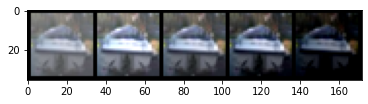

In [41]:
class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        
        # Ваш код, который применяет яркость brightness и контраст contrast.
        
        new_image = image.astype(np.float32) / 255
        new_image = contrast * (new_image - 0.5) + 0.5 + brightness
        new_image = np.clip(new_image * 255, 0, 255)
        new_image = new_image.astype(np.uint8)
        
        # Конец вашего кода.
        
        assert new_image.dtype == np.uint8
        return Image.fromarray(new_image)  # Numpy -> PIL.
    
%matplotlib inline
seminar.show_augmenter_results(BrightnessContrastAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-02-color.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Шпаргалка:
    
```(python)
cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])  # ksize: (w, h), sigmaX: число.
```

Files already downloaded and verified


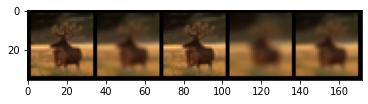

In [43]:
class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel
    
    def __call__(self, image):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        
        # Начало вашего кода.
        
        new_image = cv2.GaussianBlur(image, (kernel, kernel), kernel / 2.)
        
        # Конец вашего кода.
        return Image.fromarray(new_image)  # Numpy -> PIL.
    
%matplotlib inline
seminar.show_augmenter_results(BlurAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-03-blur.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified


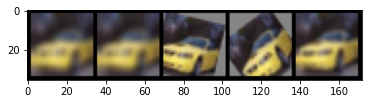

In [44]:
class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)
        
    def __call__(self, image):
        augmenter = random.choice(self._augmenters)
        return augmenter(image)
    
augmenter = RandomAugmentation(AffineAugmenter(),
                               CropAugmenter(),
                               BrightnessContrastAugmenter(),
                               BlurAugmenter())
%matplotlib inline
seminar.show_augmenter_results(augmenter, DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-04-random.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified
Trainset size: 5000


<IPython.core.display.Javascript object>


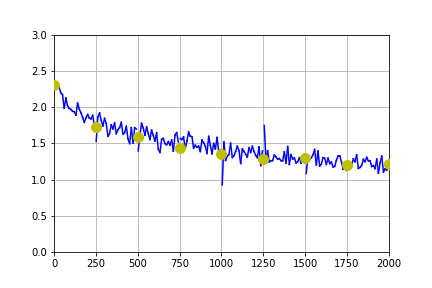

Test loss: 2.302849973297119
Test accuracy: 0.0998
Step 0
Train loss: 1.7820, learning rate: 0.0065         
Test loss: 1.724308630180359
Test accuracy: 0.3661
Step 250
Train loss: 1.5437, learning rate: 0.0043         
Test loss: 1.581165210056305
Test accuracy: 0.3973
Step 500
Train loss: 1.5052, learning rate: 0.0030         
Test loss: 1.4310870188713074
Test accuracy: 0.4754
Step 750
Train loss: 1.2852, learning rate: 0.0022         
Test loss: 1.351444197845459
Test accuracy: 0.4993
Step 1000
Train loss: 1.2463, learning rate: 0.0017         
Test loss: 1.2792926837921144
Test accuracy: 0.5299
Step 1250
Train loss: 1.3940, learning rate: 0.0014         
Test loss: 1.297404607963562
Test accuracy: 0.5184
Step 1500
Train loss: 1.0539, learning rate: 0.0013         
Test loss: 1.2053001466751099
Test accuracy: 0.5606
Step 1750
Train loss: 1.2428, learning rate: 0.0012         
Test loss: 1.2074681584835052
Test accuracy: 0.5615


In [45]:
augmentation_transform = torchvision.transforms.Compose([
    augmenter,
    transform
])
trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True, transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/08-aug-all.jpg")

# Albumentations

Большинство стандартных аугментаций уже реализовано

В torchvision классы трансформаций принимают изображение и возвращают изображение.

Классы трансформаций в albumentations принимают kwargs и возвращают словарь. За счёт этого albumentations может обрабатывать и изображения и метки.

albumentations не принимает PIL, нужно конверитровать в Numpy.

Files already downloaded and verified


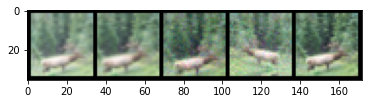

In [46]:
augmenter = albumentations.Compose([
    albumentations.ShiftScaleRotate(rotate_limit=0.25, p=0.7),
    albumentations.RandomBrightnessContrast(p=0.4),
    albumentations.RandomGamma(p=0.4),
    albumentations.Blur(blur_limit=2, p=0.1),
    albumentations.GaussNoise((10, 100), p=0.2),
    albumentations.HorizontalFlip(p=0.5)
])
%matplotlib inline
seminar.show_augmenter_results(lambda image: augmenter(image=np.array(image))["image"], DATA_ROOT)

Files already downloaded and verified
Trainset size: 5000


<IPython.core.display.Javascript object>


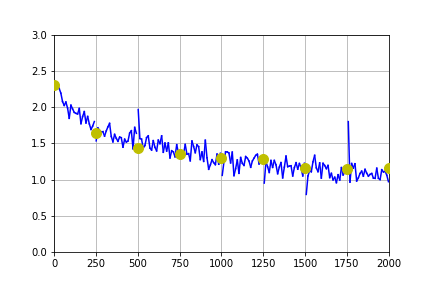

Test loss: 2.30297212638855
Test accuracy: 0.1
Step 0
Train loss: 1.6053, learning rate: 0.0065         
Test loss: 1.6407498613357543
Test accuracy: 0.3835
Step 250
Train loss: 1.5389, learning rate: 0.0043         
Test loss: 1.4371530665397645
Test accuracy: 0.4623
Step 500
Train loss: 1.3989, learning rate: 0.0030         
Test loss: 1.3557430457115174
Test accuracy: 0.4967
Step 750
Train loss: 1.3221, learning rate: 0.0022         
Test loss: 1.3025918743133544
Test accuracy: 0.5242
Step 1000
Train loss: 1.1113, learning rate: 0.0017         
Test loss: 1.2815428689956665
Test accuracy: 0.5329
Step 1250
Train loss: 1.2488, learning rate: 0.0014         
Test loss: 1.152976954460144
Test accuracy: 0.5816
Step 1500
Train loss: 0.9485, learning rate: 0.0013         
Test loss: 1.1439634238243104
Test accuracy: 0.5832
Step 1750
Train loss: 1.1220, learning rate: 0.0012         
Test loss: 1.1635832571029663
Test accuracy: 0.5858


In [47]:
augmentation_transform = torchvision.transforms.Compose([
    lambda image: augmenter(image=np.array(image))["image"],
    transform
])

trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True, transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/09-aug-album.jpg")